In [11]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten,Conv2D

#dense is a linear function
#input-input size
#flatten-changes matrix into array
from tensorflow.keras.layers import BatchNormalization,Activation,MaxPooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG,Image
import tensorflow as tf
print("Tensorflow version:" ,tf.__version__)

Tensorflow version: 2.16.2


Exploring Datasets

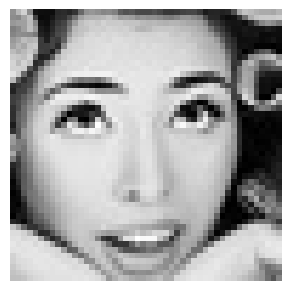

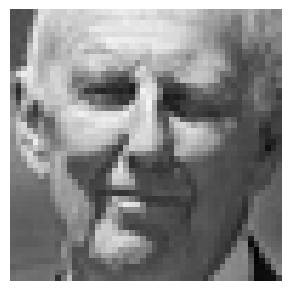

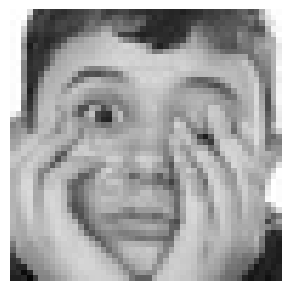

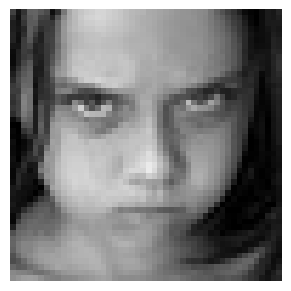

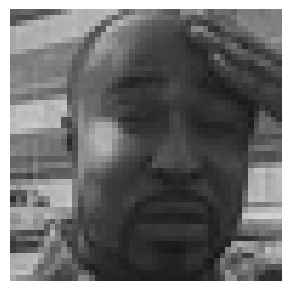

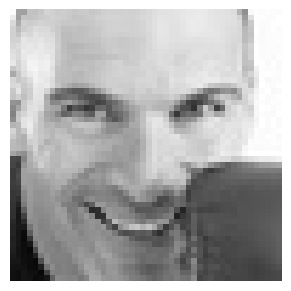

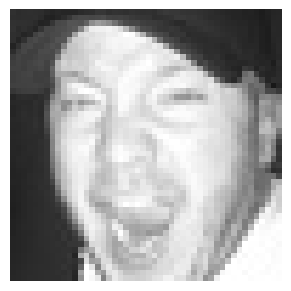

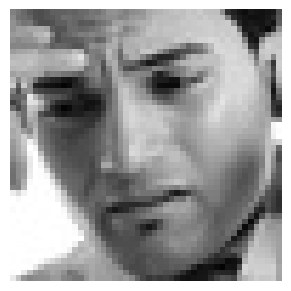

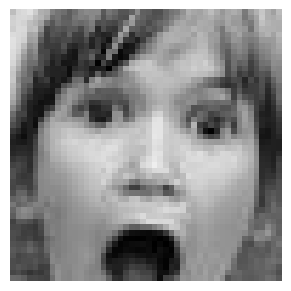

In [23]:
images = glob("train/**/**")



for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

**Preparing data for training**

In [13]:
img_size=48 #all iamges are of 48 pixel
batch_size=64
datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("train/",
                                                    target_size=(img_size,img_size),
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size,
                                                    class_mode="categorical",
                                                    shuffle = True)
datagen_validation = ImageDataGenerator()
validation_generator = datagen_train.flow_from_directory("test/",
                                                    target_size=(img_size,img_size),
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size,
                                                    class_mode="categorical",
                                                    shuffle = True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


**Defining Model**

In [14]:
def Convolution(input_tensor,filters,kernel_size):
    x = Conv2D(filters = filters , kernel_size = kernel_size ,padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)

    return x

In [15]:
def Dense_f(input_tensor,nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)

    return x

In [16]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs,32,(3,3))
    conv_2 = Convolution(inputs,64,(5,5))
    conv_3 = Convolution(inputs,128,(3,3))

    flatten = Flatten()(conv_3)

    dense_i = Dense_f(flatten,256)

    output = Dense(7,activation = "softmax")(dense_i)
    model = Model(inputs = [inputs],outputs = [output])

    model.compile(loss = ['categorical_crossentropy'],optimizer = 'adam',metrics = ['accuracy'])

    return model
    



    

In [17]:
model = model_fer((48,48,1))
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 48, 48, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 48, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    18,874,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,879,239 (72.02 MB)

 Trainable params: 18,878,471 (72.02 MB)

 Non-trainable params: 768 (3.00 KB)

**Initializing the model**

In [18]:
epochs = 25
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps =  validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.weights.h5" , monitor = 'val_accuracy' , save_weights_only = True , mode = 'max', verbose =1)
callbacks = [checkpoint]

**Training the Model**

In [19]:
history = model.fit(
x = train_generator,
steps_per_epoch = steps_per_epoch,
epochs = epochs,
validation_data = validation_generator,
validation_steps = validation_steps,
callbacks = callbacks)
    

Epoch 1/25


D:\anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3262 - loss: 1.8038
Epoch 1: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 491s 1s/step - accuracy: 0.3263 - loss: 1.8035 - val_accuracy: 0.3768 - val_loss: 1.6020
Epoch 2/25
  1/448 ━━━━━━━━━━━━━━━━━━━━ 7:10 963ms/step - accuracy: 0.4688 - loss: 1.4702

D:\anaconda\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4688 - loss: 1.4702 - val_accuracy: 0.1000 - val_loss: 1.7900
Epoch 3/25
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4825 - loss: 1.3634
Epoch 3: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 555s 1s/step - accuracy: 0.4825 - loss: 1.3634 - val_accuracy: 0.4456 - val_loss: 1.4417
Epoch 4/25
  1/448 ━━━━━━━━━━━━━━━━━━━━ 9:26 1s/step - accuracy: 0.4844 - loss: 1.3671
Epoch 4: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4844 - loss: 1.3671 - val_accuracy: 0.4000 - val_loss: 1.2014
Epoch 5/25
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5559 - loss: 1.1795
Epoch 5: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 628s 1s/step - accuracy: 0.5559 - loss: 1.1795 - val_accuracy: 0.3891 - val_loss: 1.6127
Epoch 6/25
  1/448 ━━━━━━━━━━━━━━━━━━━━ 6:54 927ms/step - accuracy: 0.54

**Model Evaluation**

In [20]:
model.evaluate(validation_generator)

113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 0.5024 - loss: 1.8105


[1.83856999874115, 0.49038729071617126]

**Plotting Loss**

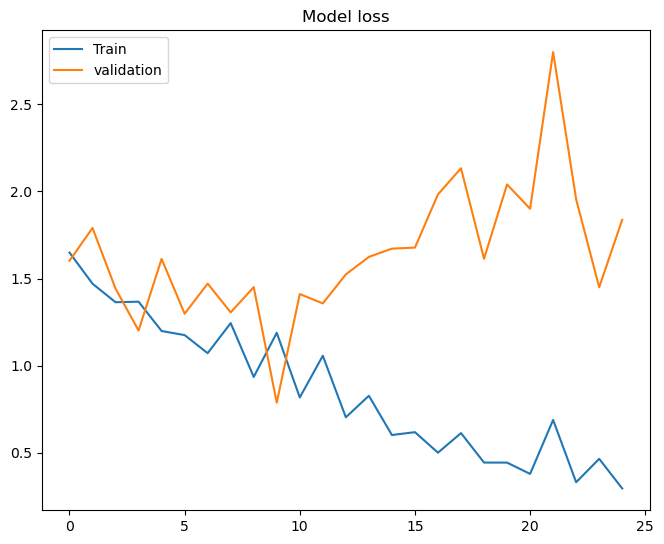

In [21]:
history_dict = history.history
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model loss')
plt.legend(['Train','validation'],loc='upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

In [22]:
model_json = model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)